<a href="https://colab.research.google.com/github/Adrian-Muino/DMML2022_Geneva/blob/main/DMML_Geneva_First_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Detecting the difficulty level of French texts by UNIL_GENEVA

##A) Prerequisites

### Imports

In [ ]:
import string
import re

import pandas as pd

import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('punkt')

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay



np.random.seed = 0

def evaluate(y_true, pred):
  """
  This method calculates the model performance metrics. Since it is a multi-class
  classification, we decided to take the weighted average 
  for the metrics that are calculated for each class.

  """

  report = {
      'accuracy':accuracy_score(y_true, pred),
      'recall':recall_score(y_true, pred, average='macro'),
      'precision':precision_score(y_true, pred, average='macro'),
      'f1_score':f1_score(y_true, pred, average='macro')
  }

  return report

def plot_confusion_matrix(y_true, pred, model):
  
  """
  A method plotting the models into a confusion matrix.
  """

  cf_matrix = confusion_matrix(y_test, pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=model.classes_)
    
  disp.plot()


reports = {}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Download the french spacy model
!python -m spacy download fr_core_news_md
!python -m spacy download fr_core_news_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-18 11:33:02.937693: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45.8 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-18 11:33:15.517885: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████

###Setting up of the environment & getting the csv

In [ ]:
# reading in the data via the Kaggle API & mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# install Kaggle
! pip install kaggle
!mkdir ~/.kaggle
#read in your Kaggle credentials from Google Drive
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# download the dataset from the competition page
! kaggle competitions download -c detecting-french-texts-difficulty-level-2022
!unzip detecting-french-texts-difficulty-level-2022.zip


Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
detecting-french-texts-difficulty-level-2022.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  detecting-french-texts-difficulty-level-2022.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace training_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training_data.csv       
replace unlabelled_test_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: unlabelled_test_data.csv  


###Loading the data

In [ ]:
df = df_train = pd.read_csv("training_data.csv")
df_unlabeled = df_test = pd.read_csv('/content/unlabelled_test_data.csv')

###Data tables

In [ ]:
df.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


In [ ]:
df_unlabeled.head()

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


###Baseline

In [ ]:
# Base line calculation
difficulty_A1_count = df.loc[df["difficulty"] == "A1"].shape[0]
difficulty_A2_count = df.loc[df["difficulty"] == "A2"].shape[0]
difficulty_B1_count = df.loc[df["difficulty"] == "B1"].shape[0]
difficulty_B2_count = df.loc[df["difficulty"] == "B2"].shape[0]
difficulty_C1_count = df.loc[df["difficulty"] == "C1"].shape[0]
difficulty_C2_count = df.loc[df["difficulty"] == "C2"].shape[0]
baserate = max(difficulty_A1_count, difficulty_A2_count,difficulty_B1_count,difficulty_B2_count,difficulty_C1_count,difficulty_C2_count)/(df["difficulty"].shape[0])
print("Baserate = ", baserate)

Baserate =  0.169375


##B) Tokenizer & vectorizer

We decided to use TFIDF vectorizer to weight more the rare words. To our opinion, rare words can be revelevant to detect complexity.

In [ ]:
# Create tokenizer function
sp_sm = spacy.load('fr_core_news_sm')

def spacy_tokenizer_sm(df):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp_sm(df)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    # Remove stop words and punctuation
    # mytokens = [ word for word in mytokens]

    # Return preprocessed list of tokens
    return mytokens


print(spacy_tokenizer_sm(df.loc[2, 'sentence']))

['le', 'test', 'de', 'niveau', 'en', 'français', 'être', 'sur', 'le', 'site', 'internet', 'de', 'le', 'école', '.']


In [ ]:
tfidf_vector_spacy = TfidfVectorizer(tokenizer=spacy_tokenizer_sm)

In [ ]:
# Define cleaning function
def nltk_tokenizer(doc):

    # Tokenize
    doc = word_tokenize(doc)

    # Remove uppercase and white spaces
    doc = [word.lower().strip() for word in doc]
    
    return doc


print(nltk_tokenizer(df.loc[2, 'sentence']))

['le', 'test', 'de', 'niveau', 'en', 'français', 'est', 'sur', 'le', 'site', 'internet', 'de', "l'école", '.']


In [ ]:
tfidf_vector_nltk = TfidfVectorizer(tokenizer=nltk_tokenizer)

## C) Classification models using two different natural language tools (SPACY & NLTK)

In [ ]:
X = df["sentence"] # the features we want to analyze
y = df["difficulty"] # the labels we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X_train

2875    Forts des expériences, parfois malheureuses, d...
4348    L'idée était de stimuler chez les élèves l'esp...
882     Attention, vous devez certifier conformes la v...
1505    Coucou mes amis, je réunis tous ceux que j'aim...
3370    C'est la couleur de nombreux fruits et légumes...
                              ...                        
1033    Les micro-changements apportés par ce type d'u...
3264    J'allais à la poste quand j'ai croisé ma cousi...
1653    Au cours des années 1970 et 1980, plusieurs gr...
2607    Stop : tout d'abord, figurez-vous que les vrai...
2732    "On s'est alors dit que le terrain commençait ...
Name: sentence, Length: 4752, dtype: object

###Logistic Regression

####With Spacy

In [ ]:
# Define classifier
LR_spacy_model= LogisticRegression(solver = "lbfgs", multi_class = 'multinomial')

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
LR_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy), ('classifier', LR_spacy_model)])

# Fit model on training set
LR_spacy_pipe.fit(X_train, y_train)

LR_spacy_pred = LR_spacy_pipe.predict(X_test)

LR_spacy_report = evaluate(y_test, LR_spacy_pred)

# Storing the model performance results in a DF called reports
reports['Logistic Regression Spacy'] = LR_spacy_report

LR_spacy_report

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.4375,
 'recall': 0.46064814814814814,
 'precision': 0.4343434343434343,
 'f1_score': 0.42726915327534526}

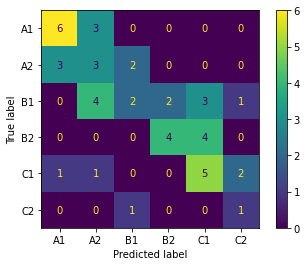

In [ ]:
plot_confusion_matrix(y_test, LR_spacy_pred, LR_spacy_pipe)

Example of type of errors

In [ ]:
badly_predicted = pd.DataFrame({'sentence':X_test[LR_spacy_pred != y_test],
              'predicted':LR_spacy_pred[LR_spacy_pred != y_test],
              'true':y_test[LR_spacy_pred != y_test]})


for i, row in badly_predicted.sample(3).iterrows():
    print(row.sentence)
    print(f"Predicted: {row.predicted}")
    print(f"Actual: {row.true}")

La nuit vient de tomber sur Calcutta et la tempête entre en ville avec une puissance terrifiante
Predicted: B1
Actual: A2
Que voulez-vous ?
Predicted: A2
Actual: B1
Il trouve bizarre que l'artiste ait quitté le concert avant la fin samedi soir dernier.
Predicted: A2
Actual: B1


####With NLTK

NLTK == Natural Language Toolkit

In [ ]:
# Define classifier
LR_model_nltk = LogisticRegression(solver = "lbfgs", multi_class = 'multinomial')

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
LR_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk), ('classifier', LR_model_nltk)])

# Fit model on training set
LR_nltk_pipe.fit(X_train, y_train)

LR_nltk_pred = LR_nltk_pipe.predict(X_test)

LR_nltk_report = evaluate(y_test, LR_nltk_pred)

# Storing the model performance results in a DF called reports
reports['Logistic Regression NLTK'] = LR_nltk_report

LR_nltk_report

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.4375,
 'recall': 0.449074074074074,
 'precision': 0.4396825396825397,
 'f1_score': 0.43258145363408523}

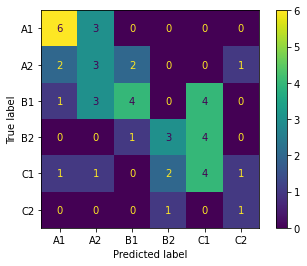

In [ ]:
plot_confusion_matrix(y_test, LR_nltk_pred, LR_nltk_pipe)

Example of type of errors

In [ ]:
badly_predicted = pd.DataFrame({'sentence':X_test[LR_nltk_pred != y_test],
              'predicted':LR_nltk_pred[LR_nltk_pred != y_test],
              'true':y_test[LR_nltk_pred != y_test]})


for i, row in badly_predicted.sample(3).iterrows():
    print(row.sentence)
    print(f"Predicted: {row.predicted}")
    print(f"Actual: {row.true}")

Vous eussiez juré que les gens la voyaient, l'entendaient rouler pesamment devant eux, retentissante de tous les trésors enfermés dans ses flancs.
Predicted: B2
Actual: C1
Le visage comprend une oreille de chaque côté, deux yeux surmontés par les sourcils et un nez au centre
Predicted: C1
Actual: B1
C'est en décembre 1967, après bien des invectives au Parlement, que sa loi relative à la régulation des naissances, dite loi Neuwirth est votée : elle autorise la vente exclusive des contraceptifs en pharmacie sur ordonnance médicale, avec autorisation parentale pour les mineures
Predicted: C2
Actual: C1


####Summary

At this stage we can say that :
* NLTK has slightly better results than Spacy.
* However it is hard to say what causes the errors.
* An area of research would be to tune the vectorizer

###kNN

####With Spacy

In [ ]:
# Define classifier
knn_spacy_model = KNeighborsClassifier()
Nknn = list(range(1, 100))
param_grid = dict(n_neighbors=Nknn)

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

knn_spacy_grid = GridSearchCV(knn_spacy_model, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)

knn_spacy_pipe = Pipeline([('vectorizer',  tfidf_vector_spacy), ('classifier', knn_spacy_grid)])
# Fit model on training set
knn_spacy_pipe.fit(X_train, y_train)

best_param_knn_spacy = knn_spacy_grid .best_params_.get('n_neighbors')
print(knn_spacy_grid .best_params_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
{'n_neighbors': 1}


In [ ]:
knn_spacy_classifier = KNeighborsClassifier(n_neighbors=best_param_knn_spacy)
# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
KNN_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy), ('classifier', knn_spacy_classifier)])

# Fit model on training set
KNN_spacy_pipe.fit(X_train, y_train)

# Predictions
KNN_spacy_pred = KNN_spacy_pipe.predict(X_test)

KNN_spacy_pred_report = evaluate(y_test, KNN_spacy_pred)

# Storing the model performance results in a DF called reports
reports['KNN Spacy'] = KNN_spacy_pred_report

KNN_spacy_pred_report

{'accuracy': 0.3333333333333333,
 'recall': 0.3703703703703703,
 'precision': 0.3325396825396825,
 'f1_score': 0.31532903016278974}

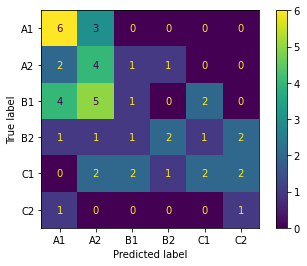

In [ ]:
plot_confusion_matrix(y_test, KNN_spacy_pred, KNN_spacy_pipe)

####With NLTK

In [ ]:
# Define classifier
knn_nltk_model = KNeighborsClassifier()
Nknn = list(range(1, 100))
param_grid = dict(n_neighbors=Nknn)

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

knn_nltk_grid = GridSearchCV(knn_nltk_model, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)

knn_nltk_pipe = Pipeline([('vectorizer',  tfidf_vector_nltk), ('classifier', knn_nltk_grid)])
# Fit model on training set
knn_nltk_pipe.fit(X_train, y_train)

best_param_knn_nltk = knn_nltk_grid .best_params_.get('n_neighbors')
print(knn_nltk_grid .best_params_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
{'n_neighbors': 1}


In [ ]:
knn_nltk_classifier = KNeighborsClassifier(n_neighbors=best_param_knn_nltk)
# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
KNN_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk), ('classifier', knn_nltk_classifier)])

# Fit model on training set
KNN_nltk_pipe.fit(X_train, y_train)

# Predictions
KNN_nltk_pred = KNN_nltk_pipe.predict(X_test)

KNN_nltk_pred_report = evaluate(y_test, KNN_nltk_pred)

# Storing the model performance results in a DF called reports
reports['KNN NLTK'] = KNN_nltk_pred_report

KNN_nltk_pred_report

{'accuracy': 0.375,
 'recall': 0.3333333333333333,
 'precision': 0.3200163398692811,
 'f1_score': 0.30954415954415954}

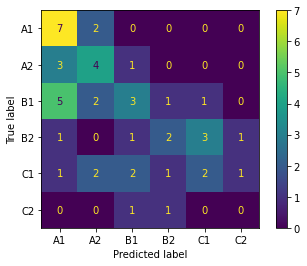

In [ ]:
plot_confusion_matrix(y_test, KNN_nltk_pred, KNN_nltk_pipe)

###Decision Tree

####With Spacy

In [ ]:
tree_spacy_model = DecisionTreeClassifier()

tree_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy),
                 ('classifier', tree_spacy_model)])


tree_spacy_pipe.fit(X_train, y_train)

tree_spacy_pred = tree_spacy_pipe.predict(X_test)

tree_spacy_report = evaluate(y_test, tree_spacy_pred)

# Store model performance results
reports['Decision Tree Spacy'] = tree_spacy_report

tree_spacy_report

{'accuracy': 0.3125,
 'recall': 0.26851851851851855,
 'precision': 0.2801180301180301,
 'f1_score': 0.2729411764705882}

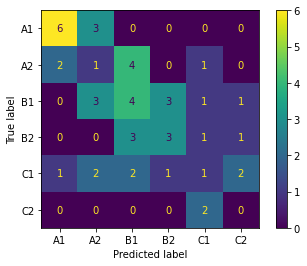

In [ ]:
plot_confusion_matrix(y_test, tree_spacy_pred, tree_spacy_pipe)

####With NLTK

In [ ]:
tree_nltk_model = DecisionTreeClassifier()

tree_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk),
                 ('classifier', tree_nltk_model)])


tree_nltk_pipe.fit(X_train, y_train)

tree_nltk_pred = tree_nltk_pipe.predict(X_test)

tree_nltk_report = evaluate(y_test, tree_nltk_pred)

# Store model performance results
reports['Decision Tree NLTK'] = tree_nltk_report

tree_nltk_report

{'accuracy': 0.3541666666666667,
 'recall': 0.38425925925925924,
 'precision': 0.3719729344729345,
 'f1_score': 0.33686459739091323}

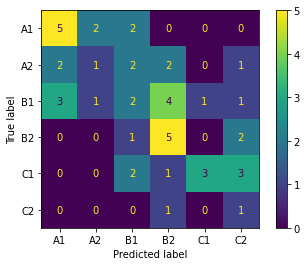

In [ ]:
plot_confusion_matrix(y_test, tree_nltk_pred, tree_nltk_pipe)

###Random Forest

####With Spacy

In [ ]:
forest_spacy_model = RandomForestClassifier()

forest_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy),
                 ('classifier', forest_spacy_model)])

forest_spacy_pipe.fit(X_train, y_train)

forest_spacy_pred = forest_spacy_pipe.predict(X_test)

forest_spacy_report = evaluate(y_test, forest_spacy_pred)

# Store model performance results
reports['Random Forest Spacy'] = forest_spacy_report

forest_spacy_report

{'accuracy': 0.4166666666666667,
 'recall': 0.45138888888888884,
 'precision': 0.373015873015873,
 'f1_score': 0.4006535947712418}

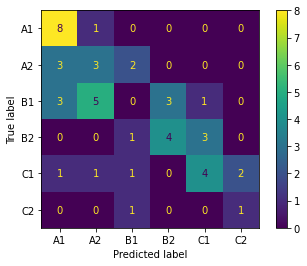

In [ ]:
plot_confusion_matrix(y_test, forest_spacy_pred, forest_spacy_pipe)

####With NLTK

In [ ]:
forest_nltk_model = RandomForestClassifier()

forest_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk),
                 ('classifier', forest_nltk_model)])

forest_nltk_pipe.fit(X_train, y_train)

forest_nltk_pred = forest_nltk_pipe.predict(X_test)

forest_nltk_report = evaluate(y_test, forest_nltk_pred)

# Store model performance results
reports['Random Forest NLTK'] = forest_nltk_report

forest_nltk_report

{'accuracy': 0.4791666666666667,
 'recall': 0.4351851851851851,
 'precision': 0.4387488328664799,
 'f1_score': 0.41215015920898274}

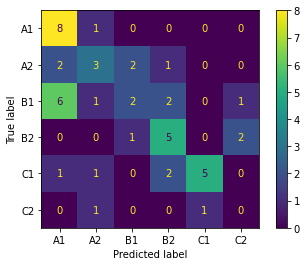

In [ ]:
plot_confusion_matrix(y_test, forest_nltk_pred, forest_nltk_pipe)

###Ridge classifier

####With Spacy

In [ ]:
ridge_spacy_model = RidgeClassifier()

ridge_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy),
                             ('classifier', ridge_spacy_model)])

ridge_spacy_pipe.fit(X_train, y_train)

ridge_spacy_pred = ridge_spacy_pipe.predict(X_test)

ridge_spacy_report = evaluate(y_test, ridge_spacy_pred)

# Store model performance results
reports['Ridge Classifier Spacy'] = ridge_spacy_report

ridge_spacy_report

{'accuracy': 0.4791666666666667,
 'recall': 0.4953703703703704,
 'precision': 0.4935897435897436,
 'f1_score': 0.4617091428236939}

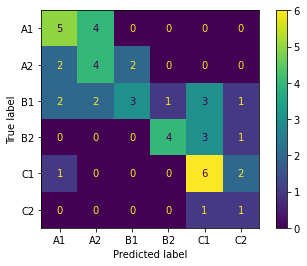

In [ ]:
plot_confusion_matrix(y_test, ridge_spacy_pred, ridge_spacy_pipe)

####With NLTK

In [ ]:
ridge_nltk_model = RidgeClassifier()

ridge_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk),
                             ('classifier', ridge_nltk_model)])

ridge_nltk_pipe.fit(X_train, y_train)

ridge_nltk_pred = ridge_nltk_pipe.predict(X_test)

ridge_nltk_report = evaluate(y_test, ridge_nltk_pred)

# Store model performance results
reports['Ridge Classifier NLTK'] = ridge_nltk_report

ridge_nltk_report

{'accuracy': 0.4791666666666667,
 'recall': 0.4907407407407407,
 'precision': 0.47007575757575754,
 'f1_score': 0.46279526430455226}

###Perceptron classifier

####With Spacy

In [ ]:
perceptron_spacy_model = Perceptron()

perceptron_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy),
                 ('classifier', perceptron_spacy_model)])


perceptron_spacy_pipe.fit(X_train, y_train)

perceptron_spacy_pred = perceptron_spacy_pipe.predict(X_test)

perceptron_spacy_report = evaluate(y_test, perceptron_spacy_pred)

# Store model performance results
reports['Perceptron Classifier Spacy'] = perceptron_spacy_report

perceptron_spacy_report


{'accuracy': 0.4166666666666667,
 'recall': 0.42361111111111116,
 'precision': 0.41383801383801383,
 'f1_score': 0.41356168198273463}

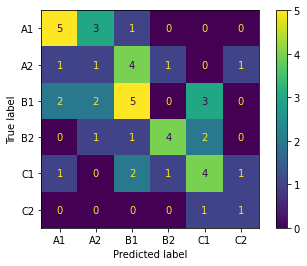

In [ ]:
plot_confusion_matrix(y_test, perceptron_spacy_pred, perceptron_spacy_pipe)

####With NLTK

In [ ]:
perceptron_nltk_model = Perceptron()

perceptron_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk),
                 ('classifier', perceptron_nltk_model)])


perceptron_nltk_pipe.fit(X_train, y_train)

perceptron_nltk_pred = perceptron_nltk_pipe.predict(X_test)

perceptron_nltk_report = evaluate(y_test, perceptron_nltk_pred)

# Store model performance results
reports['Perceptron Classifier NLTK'] = perceptron_nltk_report

perceptron_nltk_report


{'accuracy': 0.4583333333333333,
 'recall': 0.46759259259259256,
 'precision': 0.4559163059163059,
 'f1_score': 0.43972431077694235}

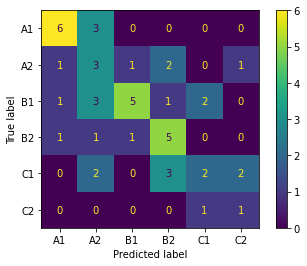

In [ ]:
plot_confusion_matrix(y_test, perceptron_nltk_pred, perceptron_nltk_pipe)

###GradientBoostingClassifier

####With Spacy

In [ ]:
gbc_spacy_model = GradientBoostingClassifier()

gbc_spacy_pipe = Pipeline([('vectorizer',  tfidf_vector_spacy),
                 ('classifier', gbc_spacy_model)])

gbc_spacy_pipe.fit(X_train, y_train)

gbc_spacy_pred = gbc_spacy_pipe.predict(X_test)

gbc_spacy_report = evaluate(y_test, gbc_spacy_pred)

# Store model performance results
reports['Gradient Boosting Classifier Spacy'] = gbc_spacy_report

gbc_spacy_report


{'accuracy': 0.3541666666666667,
 'recall': 0.3773148148148148,
 'precision': 0.3591570466570466,
 'f1_score': 0.34553376906318084}

####With NLTK

In [ ]:
gbc_nltk_model = GradientBoostingClassifier()

gbc_nltk_pipe = Pipeline([('vectorizer',  tfidf_vector_nltk),
                 ('classifier', gbc_nltk_model)])

gbc_nltk_pipe.fit(X_train, y_train)

gbc_nltk_pred = gbc_nltk_pipe.predict(X_test)

gbc_nltk_report = evaluate(y_test, gbc_nltk_pred)

# Store model performance results
reports['Gradient Boosting Classifier NLTK'] = gbc_nltk_report

gbc_nltk_report

{'accuracy': 0.3958333333333333,
 'recall': 0.4236111111111111,
 'precision': 0.3846509971509972,
 'f1_score': 0.38009008964891317}

###XGB classifier

####With Spacy

In [ ]:
from xgboost import XGBClassifier

xgb_spacy_model = XGBClassifier()
xgb_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy), ('classifier', xgb_spacy_model)])

xgb_spacy_pipe.fit(X_train, y_train)

xgb_spacy_pred = xgb_spacy_pipe.predict(X_test)

xgb_spacy_report = evaluate(y_test, xgb_spacy_pred)

# Store model performance results
reports['XGB Classifier Spacy'] = xgb_spacy_report

xgb_spacy_report

{'accuracy': 0.3541666666666667,
 'recall': 0.3796296296296296,
 'precision': 0.35509259259259257,
 'f1_score': 0.3409710550887021}

####With NLTK

In [ ]:
xgb_nltk_model = XGBClassifier()
xgb_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk), ('classifier', xgb_nltk_model)])

xgb_nltk_pipe.fit(X_train, y_train)

xgb_nltk_pred = xgb_nltk_pipe.predict(X_test)

xgb_nltk_report = evaluate(y_test, xgb_nltk_pred)

# Store model performance results
reports['XGB Classifier NLTK'] = xgb_nltk_report 

xgb_nltk_report

{'accuracy': 0.3333333333333333,
 'recall': 0.3009259259259259,
 'precision': 0.28558201058201055,
 'f1_score': 0.2829635362917096}

###SGD Classifier

####With spacy

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_spacy_model = SGDClassifier()

sgd_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy), ('classifier', sgd_spacy_model)])

sgd_spacy_pipe.fit(X_train, y_train)

sgd_spacy_pred = sgd_spacy_pipe.predict(X_test)

sgd_spacy_report = evaluate(y_test, sgd_spacy_pred)

# Store model performance results
reports['SGD Classifier Spacy'] = sgd_spacy_report

sgd_spacy_report


{'accuracy': 0.4375,
 'recall': 0.45601851851851855,
 'precision': 0.46015234765234764,
 'f1_score': 0.43717960745824525}

####With NLTK

In [ ]:
sgd_nltk_model = SGDClassifier()

sgd_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk), ('classifier', sgd_nltk_model)])

sgd_nltk_pipe.fit(X_train, y_train)

sgd_nltk_pred = sgd_nltk_pipe.predict(X_test)

sgd_nltk_report = evaluate(y_test, sgd_nltk_pred)

# Store model performance results
reports['SGD Classifier NLTK'] = sgd_nltk_report

sgd_nltk_report


{'accuracy': 0.4791666666666667,
 'recall': 0.4884259259259259,
 'precision': 0.48024891774891776,
 'f1_score': 0.46347609219126246}

###BERT + CAMEMBERT Model to try too

##D) Models Comparison

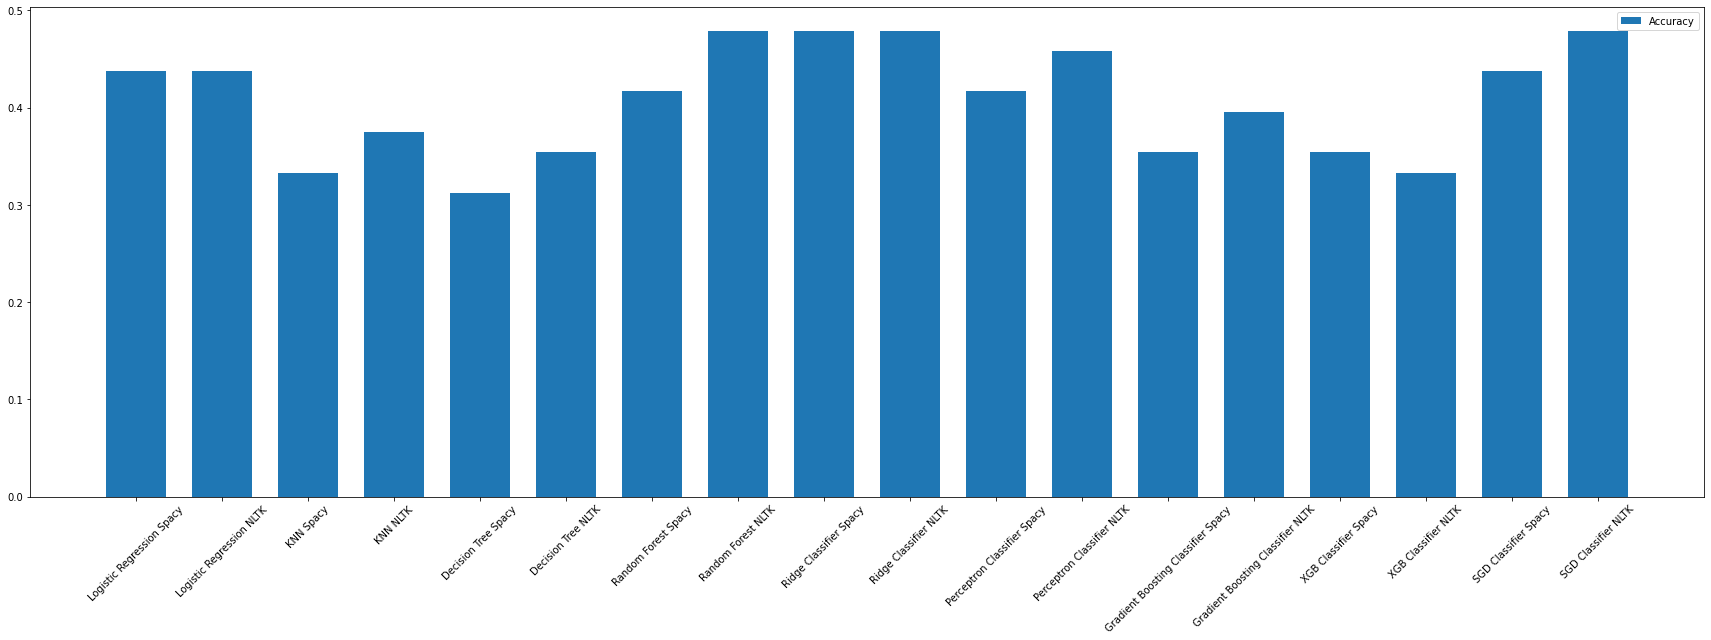

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30,9))

width = 0.70
labels = reports.keys()
report_values_accuracy = [x['accuracy'] for x in reports.values()]

ax.bar(labels, report_values_accuracy, 
        label='Accuracy', width=width)

plt.xticks(rotation=45)
ax.legend()

In [ ]:
models_comparaison_table2 = pd.DataFrame({'Model name':pd.Series(reports.keys()),'Accuracy':pd.Series(report_values_accuracy)}).sort_values(by=['Accuracy'],ascending=False)
models_comparaison_table2.set_index(['Model name']).T

Model name,Ridge Classifier NLTK,Random Forest NLTK,Ridge Classifier Spacy,SGD Classifier NLTK,Perceptron Classifier NLTK,Logistic Regression NLTK,SGD Classifier Spacy,Logistic Regression Spacy,Random Forest Spacy,Perceptron Classifier Spacy,Gradient Boosting Classifier NLTK,KNN NLTK,Decision Tree NLTK,Gradient Boosting Classifier Spacy,XGB Classifier Spacy,KNN Spacy,XGB Classifier NLTK,Decision Tree Spacy
Accuracy,0.479167,0.479167,0.479167,0.479167,0.458333,0.4375,0.4375,0.4375,0.416667,0.416667,0.395833,0.375,0.354167,0.354167,0.354167,0.333333,0.333333,0.3125


### E) Model with embedding text

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model= SentenceTransformer("distiluse-base-multilingual-cased-v1")

In [ ]:
!python -m spacy download fr_core_news_sm
!python -m spacy link fr_core_news_sm fr
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
sp = spacy.load('fr_core_news_sm')

# Create tokenizer function
def spacy_tokenizer3(df):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(df)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens]

    sentence=" ".join(mytokens)

    return sentence

In [ ]:
df["tokenize"]= df["sentence"].apply(spacy_tokenizer3)

In [ ]:
df["embeddings"]=df["tokenize"].apply(model.encode)

In [ ]:
X = df["embeddings"].to_list()
y =df["difficulty"].to_list()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver = "saga", multi_class = 'multinomial')
LR.fit(X_train,y_train)

In [ ]:
from sklearn import metrics
predicted = LR.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))

### F)Model using TensorFlow

In [ ]:
import string
import re

import pandas as pd

import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('punkt')

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay



np.random.seed = 0

def evaluate(y_true, pred):
  """
  This method calculates the model performance metrics. Since it is a multi-class
  classification, we decided to take the weighted average 
  for the metrics that are calculated for each class.

  """

  report = {
      'accuracy':accuracy_score(y_true, pred),
      'recall':recall_score(y_true, pred, average='macro'),
      'precision':precision_score(y_true, pred, average='macro'),
      'f1_score':f1_score(y_true, pred, average='macro')
  }

  return report

def plot_confusion_matrix(y_true, pred, model):
  
  """
  A method plotting the models into a confusion matrix.
  """

  cf_matrix = confusion_matrix(y_test, pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=model.classes_)
    
  disp.plot()


reports = {}


In [ ]:
# Download the french spacy model
!python -m spacy download fr_core_news_md
!python -m spacy download fr_core_news_sm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df["difficulty"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['difficulty'].value_counts().plot.barh(title="Setences by Difficulty Level", 
                                                 ylabel="Level",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df['difficulty'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

In [ ]:
# map topic descriptions to labels
df['Level'] = df['difficulty'].map({'A1': 0,
                                    'A2': 1,
                                    'B1': 2,
                                    'B2': 3,
                                    'C1': 4,
                                    'C2': 5,})

# drop unused column
df = df.drop(["difficulty"], axis=1)

df.head()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["Level"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['sentence'], y, test_size=0.2)

In [ ]:
!pip install tensorflow_hub
!pip install tensorflow_text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text


preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
preprocessor_2 = hub.KerasLayer("https://tfhub.dev/google/wiki40b-lm-fr/1")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "Les coûts kilométriques réels peuvent diverger sensiblement des valeurs moyennes en fonction du moyen de transport utilisé, du taux d'occupation ou du taux de remplissage, de l'infrastructure utilisée, de la topographie des lignes, du flux de trafic, etc."]
)

In [ ]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor_2(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                     patience = 3,
                                                     restore_best_weights = True,
                                                      start_from_epoch=3)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)
#model.compile(
#    optimizer=tf.keras.optimizers.Adam(3e-5),
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#    metrics=['accuracy']
#)



model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

In [ ]:
df_unlabeled = df_test = pd.read_csv('/content/unlabelled_test_data.csv')
df_unlabeled ["tokenize"]= df_unlabeled ["sentence"].apply(spacy_tokenizer3)
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


predict_class(df_unlabeled["tokenize"])

In [ ]:
predictions_to_submit = pd.DataFrame(predict_class(df_unlabeled["sentence"]))
predictions_to_submit.columns = ['difficulty']

In [ ]:
predictions_to_submit

In [ ]:
predictions_to_submit['difficulty'] = predictions_to_submit['difficulty'].map({0: "A1",
                                    1: 'A2',
                                    2: 'B1',
                                    3: 'B2',
                                    4: 'C1',
                                    5: 'C2'})
predictions_to_submit = predictions_to_submit.rename_axis("id")
predictions_to_submit

In [ ]:
predictions_to_submit.to_csv("Geneva_predictions_BertTensor7.csv")

### G) Code for submission

###First Submission

In [ ]:
# Used the best model in terms of accuracy
geneva_predictions_ridge_nltk = ridge_nltk_pipe.predict(df_unlabeled["sentence"])

first_submission = pd.DataFrame(geneva_predictions_ridge_nltk,columns=["difficulty"])
first_submission = first_submission.rename_axis("id")

first_submission.to_csv("Geneva_predictions_ridge_nltk.csv") 

In [ ]:
first_submission

,difficulty
id,
0,C2
1,A2
2,A1
3,B1
4,C2
...,...
1195,B1
1196,A2
1197,C2


###Second Submission

In [ ]:
# Used the best model in terms of accuracy
geneva_predictions_sgd_nltk = sgd_nltk_pipe.predict(df_unlabeled["sentence"])

second_submission = pd.DataFrame(geneva_predictions_sgd_nltk ,columns=["difficulty"])
second_submission = second_submission.rename_axis("id")

second_submission.to_csv("Geneva_predictions_sgd_nltk.csv") 

In [ ]:
second_submission

,difficulty
id,
0,C2
1,A2
2,A1
3,B1
4,C2
...,...
1195,B1
1196,A2
1197,C2


###Third Submission

In [ ]:
# Used the best model in terms of accuracy
geneva_predictions_LR_nltk = LR_nltk_pipe.predict(df_unlabeled["sentence"])

third_submission = pd.DataFrame(geneva_predictions_LR_nltk ,columns=["difficulty"])
third_submission = third_submission.rename_axis("id")

third_submission.to_csv("Geneva_predictions_LR_nltk.csv") 

In [ ]:
third_submission

,difficulty
id,
0,C2
1,A2
2,A1
3,B1
4,C2
...,...
1195,B1
1196,A2
1197,C2
